In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py

In [2]:
import string_constants as sc
import reading_util as ru
import dataset_util as du
import parameter as pa
import quantile_regression_dnn as qr
import data_sample as ds
import plotting_util as pu
import flat_cut as fc

Using TensorFlow backend.


# runtime parameters

In [3]:
# share of total qcd signal region data for QR training (rest for GOF test)
QR_train_share = 0.25 #0.2
# constant fraction wrt dijet mass of BG accepted
quantile = pa.quantile_dict['q1'] # q1 = 1%
# strategy for combining loss-jet-1 and loss-jet-2
strategy = pa.loss_strategy_dict['s5'] # s5 = L1 & L2

# read in data (qcd and signal)

In [4]:
SM_sample = 'qcdSigAll'
qcd_path = os.path.join( sc.concat_result_dir, sc.sample_loc[SM_sample] + sc.concat_result_suffix )
qcd_data_total = ru.read_results_to_dataframe( qcd_path )

In [5]:
BSM_sample = 'GtoWW30na'
signal_path = os.path.join( sc.concat_result_dir, sc.sample_loc[BSM_sample] + sc.concat_result_suffix )
signal_sample_data = ru.read_results_to_dataframe( signal_path )

## split qcd data into train and test set 

In [6]:
qcd_data_train, qcd_data_test = du.split_dataset_train_test( qcd_data_total, QR_train_share )

# Selector

In [ ]:
combined_loss = strategy( qcd_data_train )
selector = QuantileRegressionOverflowBinSelector( quantile.val )
selector.fit( qcd_data_train['mJJ'].values, combined_loss )

# Train QR DNN

In [7]:
# train QR
combined_loss = strategy( qcd_data_train )
model = qr.Quantile_Regression( quantile.val )
model.fit( qcd_data_train['mJJ'].values, combined_loss )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

## get regression cut point

In [8]:
# get overflow bin (max accepted mjj) for regression cut
sel = model.select_events( qcd_data_train['mJJ'].values, combined_loss ) # get selection for qcd training set
max_acc_mjj = np.max(qcd_data_train['mJJ'][sel]) # get max mjj in accepted set

# OR(!) use Flat Cut

In [61]:
reload(fc)
combined_loss = strategy( qcd_data_train )
model = fc.FlatCut( quantile.val )
model.fit( combined_loss )

# VAE Boost

## get selection for qcd sample

In [62]:
qcd_sample = ds.DataSample( 'qcdTest', qcd_data_test )
qcd_sample.add_feature('combiLoss', strategy( qcd_data_test ))

In [63]:
#qcd_selection = model.select_events_regression_cut( qcd_sample['mJJ'].values, qcd_sample['combiLoss'].values, max_acc_mjj )
# OR (flat cut)
qcd_selection = model.select_events( qcd_sample['combiLoss'].values )

In [64]:
qcd_sample.add_feature('sel',qcd_selection)

## get selection for signal sample

In [65]:
signal_sample = ds.DataSample( BSM_sample, signal_sample_data )
signal_sample.add_feature('combiLoss', strategy( signal_sample_data ) )

In [66]:
#signal_selection = model.select_events_regression_cut( signal_sample['mJJ'].values, signal_sample['combiLoss'].values, max_acc_mjj )
# OR (flat cut)
signal_selection = model.select_events( signal_sample['combiLoss'].values )

In [67]:
signal_sample.add_feature('sel', signal_selection)

# Binning for bump hunt

In [68]:
def get_bin_counts_total_acc_rej( boosted_sample, bin_edges ):
    accepted = boosted_sample[ boosted_sample['sel'] ]
    rejected = boosted_sample[ ~boosted_sample['sel'] ]
    tot_count, _ = np.histogram( boosted_sample['mJJ'], bins=bin_edges )
    acc_count, _ = np.histogram( accepted['mJJ'], bins=bin_edges )
    rej_count, _ = np.histogram( rejected['mJJ'], bins=bin_edges ) 
    return [tot_count, acc_count, rej_count]

In [69]:
bin_edges = [1126,1181,1246,1313,1383,1455,1530,1607,1687,1770,1856,1945,2037,2132,2231,2332,2438,2546,2659,2775,2895,3019,3147,3279,3416,3558,3704,3854,4010,4171,4337,4509,4686,4869,5058,5253,5500,5663,5877,6099,6328,6564,6808]

In [70]:
qcd_tot_cnt, qcd_acc_cnt, qcd_rej_cnt = get_bin_counts_total_acc_rej( qcd_sample, bin_edges )

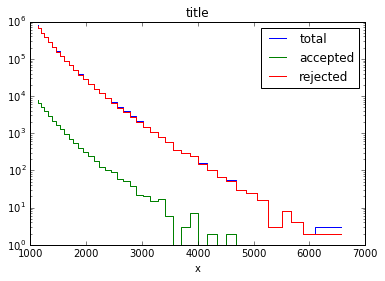

In [71]:
pu.plot_step(bin_edges[:-1],[qcd_tot_cnt, qcd_acc_cnt, qcd_rej_cnt],labels=['total','accepted','rejected'])

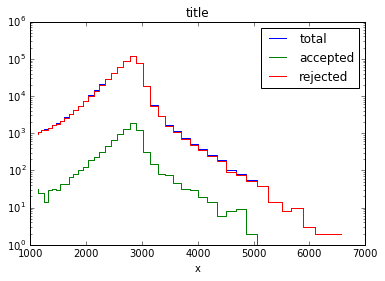

In [72]:
sig_tot_cnt, sig_acc_cnt, sig_rej_cnt = get_bin_counts_total_acc_rej( signal_sample, bin_edges )
pu.plot_step(bin_edges[:-1],[sig_tot_cnt, sig_acc_cnt, sig_rej_cnt],labels=['total','accepted','rejected'])

# write bincounts

In [73]:
def write_bin_counts( datasamples, bincounts, bin_edges, file_path ):
    with h5py.File( file_path, 'w' ) as file_bin_counts:
        for sample, counts in zip(datasamples,bincounts):
            file_bin_counts.create_dataset(sample, data=counts)
        file_bin_counts.create_dataset('bin_count_labels',data=['total','accepted','rejected'])
        file_bin_counts.create_dataset('bin_edges',data=bin_edges)

In [75]:
date = datetime.date.today().strftime("%m%d")
bin_file_path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/quant_1pct_loss_maxl1l2/bin_counts_flat_cut_'+date+'.h5'
qcd_counts = np.stack((qcd_tot_cnt,qcd_acc_cnt,qcd_rej_cnt))
sig_counts = np.stack((sig_tot_cnt,sig_acc_cnt,sig_rej_cnt))
write_bin_counts([SM_sample,BSM_sample],[qcd_counts,sig_counts],bin_edges,bin_file_path)

# check dumped data

In [76]:
bin_file_path

'/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/quant_1pct_loss_maxl1l2/bin_counts_flat_cut_0418.h5'

[u'GtoWW30na', u'bin_count_labels', u'bin_edges', u'qcdSigAll']


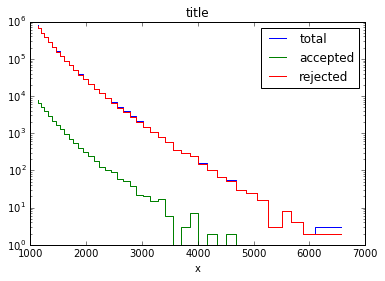

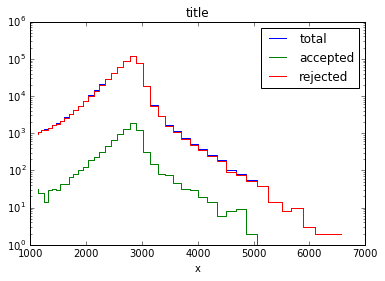

In [77]:
f = h5py.File(bin_file_path,'r')
print(f.keys())
qcd_counts = f.get('qcdSigAll')
sig_counts = f.get('GtoWW30na')
qcd_tot, qcd_acc, qcd_rej = qcd_counts[0], qcd_counts[1], qcd_counts[2]
sig_tot, sig_acc, sig_rej = sig_counts[0], sig_counts[1], sig_counts[2]
pu.plot_step(bin_edges[:-1],[qcd_tot, qcd_acc, qcd_rej],labels=['total','accepted','rejected'])
pu.plot_step(bin_edges[:-1],[sig_tot, sig_acc, sig_rej],labels=['total','accepted','rejected'])
f.close()